# Import Packages

In [1]:
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

#For Feature Engineering
import re
from scipy import sparse as sp
import string
import nltk
from nltk.tokenize import wordpunct_tokenize,TweetTokenizer
from sklearn.impute import KNNImputer
from matplotlib import pyplot as plt
import seaborn as sns
sns.set() 

import pandas as pd
import numpy as np
import gensim 
from time import time
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity


# Run it to obtain reproducible results across machines (from keras.io)import numpy as np
import tensorflow as tf
import random as rn
import os
from tensorflow.keras import optimizers,backend as K
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

#For Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Reshape, Dropout, Activation,Embedding,Flatten,BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

# Import Supporting Files

In [ ]:
#Google Word2Vec Pretrained Model
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('C:/Users/Louis Owen/Desktop/NLP_Stacking_Ensemble/Pre-Trained Word Embedding/GoogleNews-vectors-negative300.bin', binary=True) 

# #GloVe Pretrained Model
# link ='https://drive.google.com/open?id=1p1IN9O_fpSQzPTFB5Y8CCOMXPIPU1WGV'
# fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('glove.twitter.27B.200d.txt')   
# def loadGloveModel(gloveFilePath):
#     print("Loading Glove Model")
#     f = open(gloveFilePath,'r',encoding='utf-8')
#     model = {}
#     for line in f:
#         splitLine = line.split()
#         word = splitLine[0]
#         embedding = np.array([float(val) for val in splitLine[1:]])
#         model[word] = embedding
#     print("Done.",len(model)," words loaded!")
#     return model
# model_GloVe=loadGloveModel('glove.twitter.27B.200d.txt')

# Import Data

In [3]:
df_train = pd.read_csv('C:/Users/Louis Owen/Desktop/NLP_Stacking_Ensemble/df_train_final.csv')
df_train=df_train.drop(['Unnamed: 0','index'],1)

df_test = pd.read_csv('C:/Users/Louis Owen/Desktop/NLP_Stacking_Ensemble/df_test_final.csv')
df_test=df_test.drop(['Unnamed: 0','index'],1)

df_train=df_train.drop(columns=['created_at','official_account','sentiment','total_likes'])
df_test=df_test.drop(columns=['created_at','official_account','sentiment','total_likes'])

# Function Definition

In [0]:
def grid_model(df,hidden_nodes_1,hidden_nodes_2,hidden_nodes_3,l2_regularizer,input_dropout,hidden_dropout,activation_list,optimizer,epochs,batch_normalization=False,batch_size=32,two_layer=False,sentence_vector=False):
    '''
    Function for hyperparameter tuning
    '''
    #Initiate StratifiedKFold Class
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=500)
    #Prepare stratify variable
    stratify=df['source']
    #begin hyperparameter tuning looping
    for act in activation_list:
      cvscores = [] #list containing metrics score for each fold
      start=time()
      for train,val in kfold.split(df,stratify):
        df_train=df.loc[train,:]
        df_val=df.loc[val,:]
        df_train=df_train.reset_index(drop=True)
        df_val=df_val.reset_index(drop=True)

        #Filter Data
        if not sentence_vector:
          #Feature Engineering
          df_train,df_val=PMI(df_train,df_val)
          for gram in [1,2,3,4]:
            df_train,df_val=rf_ngram(df_train,df_val,gram=gram)

          df_train=df_train.drop(['cashtag','spans','text','clean_text','base_text','source'],1)
          df_val=df_val.drop(['cashtag','spans','text','clean_text','base_text','source'],1)
        else:
          df_train=df_train.drop('source',1)
          df_val=df_val.drop('source',1)

        #Split data into dependent and independent variable
        X_train=df_train.drop(['sentiment score'],1)
        X_val=df_val.drop(['sentiment score'],1)
        y_train=df_train['sentiment score']
        y_val=df_val['sentiment score']

        #Impute Missing Values
        imputer = KNNImputer(n_neighbors=3)
        X_train=pd.DataFrame(imputer.fit_transform(X_train))
        X_val=pd.DataFrame(imputer.fit_transform(X_val))

        #Define MLP
        model = Sequential()
        model.add(Dropout(input_dropout, input_shape=(X_train.shape[1],),seed=0))
        model.add(Dense(hidden_nodes_1,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l1(l2_regularizer)))
        model.add(Activation(act))
        model.add(Dropout(hidden_dropout))
        if batch_normalization:
          model.add(BatchNormalization())
        model.add(Dense(hidden_nodes_2,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l1(l2_regularizer)))
        
        if not two_layer:
          model.add(Activation(act))
          model.add(Dropout(hidden_dropout))
          if batch_normalization:
            model.add(BatchNormalization())
          model.add(Dense(hidden_nodes_3,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l1(l2_regularizer)))
          model.add(Activation('tanh'))
        else:
          model.add(Activation('tanh'))
  
        model.add(Dense(1))

        model.compile(loss='MSE',optimizer=optimizer,metrics=['cosine_proximity']) 
        history=model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=False,
                  validation_data=(X_val, y_val))
        score_train, cos_train = model.evaluate(X_train, y_train, verbose=False)
        score_val, cos_val = model.evaluate(X_val, y_val, verbose=False)
        cvscores.append(cos_val)

        print('Train Cosine Similarity: {}, Val Cosine Similarity: {}'.format(cos_train,cos_val))
        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.show()
        print('')
        print('')

      end=time()
      print('Time Elapsed: {}'.format(end-start))
      print('Epochs: {}'.format(epochs))
      print('Hidden Nodes 1: {}'.format(hidden_nodes_1))
      print('Hidden Nodes 2: {}'.format(hidden_nodes_2))
      print('Hidden Nodes 3: {}'.format(hidden_nodes_3))
      print('Input Dropout Rate: {}'.format(input_dropout))
      print('Hidden Dropout Rate: {}'.format(hidden_dropout))
      print('Activation Function: {}'.format(act))
      print('Optimizer: {}'.format(optimizer))
      print('Stratified 10-Fold Cosine Similarity Avg Score: {}, Std Score: {}'.format(np.mean(cvscores),np.std(cvscores)))
      print('')
  
def model(df_train,hidden_nodes_1,hidden_nodes_2,hidden_nodes_3,l2_regularizer,input_dropout,hidden_dropout,act,optimizer,epochs,batch_normalization=False,batch_size=32,two_layer=False,sentence_vector=False):
    '''
    Function for hyperparameter tuning
    '''

    #Filter Data
    if not sentence_vector:
      #Feature Engineering
      df_train,_=PMI(df_train,df_train)
      for gram in [1,2,3,4]:
        df_train,_=rf_ngram(df_train,df_train,gram=gram)
      
      df_train=df_train.drop(['cashtag','spans','text','clean_text','base_text','source'],1)
    else:
      df_train=df_train.drop('source',1)

    #Split data into dependent and independent variable
    X_train=df_train.drop(['sentiment score'],1)
    y_train=df_train['sentiment score']

    #Impute Missing Values
    imputer = KNNImputer(n_neighbors=3)
    X_train=pd.DataFrame(imputer.fit_transform(X_train))

    #Define MLP
    model = Sequential()
    model.add(Dropout(input_dropout, input_shape=(X_train.shape[1],),seed=0))
    model.add(Dense(hidden_nodes_1,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l1(l2_regularizer)))
    model.add(Activation(act))
    model.add(Dropout(hidden_dropout))
    if batch_normalization:
      model.add(BatchNormalization())
    model.add(Dense(hidden_nodes_2,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l1(l2_regularizer)))

    if not two_layer:
      model.add(Activation(act))
      model.add(Dropout(hidden_dropout))
      if batch_normalization:
        model.add(BatchNormalization())
      model.add(Dense(hidden_nodes_3,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l1(l2_regularizer)))
      model.add(Activation('tanh'))
    else:
      model.add(Activation('tanh'))

    model.add(Dense(1))

    model.compile(loss='MSE',optimizer=optimizer,metrics=['cosine_proximity']) 
    history=model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=False)
    return model

def tokenize(sentence):
  '''
  tokenize input into token
  '''
  token_list=nltk.regexp_tokenize(sentence, pattern=r"\s|[\.,;]\D", gaps=True)
  return(token_list)

def min_multiple_list(S):
  '''
  Minimum Pooling
  '''
  it=range(len(S)-1)
  minim=S[0]
  for i in it:
      minim=np.minimum(minim,S[i])
  return(minim)

def max_multiple_list(S):
  '''
  Maximum Pooling
  '''
  it=range(len(S)-1)
  maxim=S[0]
  for i in it:
      maxim=np.maximum(maxim,S[i])
  return(maxim)
  
def W2V_sentence_embedding(df,span=False):
  '''
  return dataframe for W2V sentence embedding
  '''
  if not span:
    column='clean_text'
  else:
    column='spans'
    
  zero=np.array([float(0) for i in range(300)])
  nan=np.array([np.nan for i in range(300)])
  vec_W2V=lambda x: model_w2v[x] if x in model_w2v else zero
  W2V_avg=df[column].apply(lambda sent: pd.Series(tokenize(sent)).apply(lambda x: vec_W2V(x)).mean() if type(sent)==str else nan)
  
  W2V_df=pd.DataFrame(dict(zip(W2V_avg.index, W2V_avg.values))).T
  W2V_df['source']=df['source']
  W2V_df['sentiment score']=df['sentiment score']
  col=['x'+str(i) for i in W2V_df.drop(['source','sentiment score'],1).columns.tolist()]
  col.append('source')
  col.append('sentiment score')
  W2V_df.columns=col
  return(W2V_df)

def GloVe_sentence_embedding(df,span=False):
  '''
  return dataframe for GloVe sentence embedding
  '''
  if not span:
    column='clean_text'
  else:
    column='spans'
    
  zero=np.array([float(0) for i in range(200)])
  nan=np.array([np.nan for i in range(200)])
  vec_GloVe=lambda x: model_GloVe[x] if x in model_GloVe else zero
  GloVe_avg=df[column].apply(lambda sent: pd.Series(tokenize(sent)).apply(lambda x: vec_GloVe(x)).mean() if type(sent)==str else nan)

  GloVe_df=pd.DataFrame(dict(zip(GloVe_avg.index, GloVe_avg.values))).T  
  GloVe_df['source']=df['source']
  GloVe_df['sentiment score']=df['sentiment score']
  col=['x'+str(i) for i in GloVe_df.drop(['source','sentiment score'],1).columns.tolist()]
  col.append('source')
  col.append('sentiment score')
  GloVe_df.columns=col
  return(GloVe_df)

def tokenize(sentence):
  '''
  tokenize input sentence into token
  '''
  return (nltk.regexp_tokenize(sentence, pattern=r"\s|[\.,;]\D", gaps=True))

def n_grams_handled(sentence):
  '''
  Filter before generate n-gram
  '''
  try:
    tk=TweetTokenizer()
    cashtag_pat=r'\$[^\s]+'
    hashtag_pat=r'#([^\s]+)'
    word_number_pat=r'\w*\d\w*'
  
    #Remove word which has length < 2
    stripped=' '.join([word for word in sentence.split() if len(word)>=2])
  
    #Remove hashtag
    hashtag_handled= re.sub(hashtag_pat,"", stripped)
  
    #Remove cashtag
    cashtag_handled= re.sub(cashtag_pat,"", hashtag_handled)
    
    #Remove word with number
    number_handled= re.sub(word_number_pat,"", cashtag_handled)
  
    #Remove unnecesary white spaces
    words = tk.tokenize(number_handled)
    words = [x for x in words if x not in string.punctuation]
    clean_sentence=(" ".join(words)).strip()
    return  clean_sentence
  except:
    return sentence

def rf_ngram(df_train,df_test,gram): 
  '''
  create rf-ngram
  '''
  def sentence_sparse(sentence,gram,rf_ngram,sparse_rf_ngram):
    #Initiate Linke List Sparse Matrix
    zero_sparse=sp.lil_matrix( (1,len(rf_ngram)), dtype=float)
    #Assign Value of rf_ngram to each word in sentence
    splitted_text=tokenize(n_grams_handled(sentence))
    #Unigram
    if gram==1:
      for word in splitted_text:
        if word in rf_ngram.index:
          zero_sparse[0,rf_ngram.index.get_loc(word)]+=sparse_rf_ngram[0,rf_ngram.index.get_loc(word)]
      #Convert LinkedList Sparse Matrix into CSR Sparse Matrix
      sparse=zero_sparse.tocsr()
    #Bigram
    elif gram==2:
      bigram=lambda x: splitted_text[x]+' '+splitted_text[x+1]
      it_2_gram=range(len(splitted_text)-1)
      for i in it_2_gram:
        if bigram(i) in rf_ngram.index:
          zero_sparse[0,rf_ngram.index.get_loc(bigram(i))]+=sparse_rf_ngram[0,rf_ngram.index.get_loc(bigram(i))]
      #Convert LinkedList Sparse Matrix into CSR Sparse Matrix
      sparse=zero_sparse.tocsr()
    #Trigram
    elif gram==3:
      trigram=lambda x: splitted_text[x]+' '+splitted_text[x+1]+' '+splitted_text[x+2]
      it_3_gram=range(len(splitted_text)-2)
      for i in it_3_gram:
        if trigram(i) in rf_ngram.index:
          zero_sparse[0,rf_ngram.index.get_loc(trigram(i))]+=sparse_rf_ngram[0,rf_ngram.index.get_loc(trigram(i))]
      #Convert LinkedList Sparse Matrix into CSR Sparse Matrix
      sparse=zero_sparse.tocsr()
    #4grams
    elif gram==4:
      fourgram=lambda x: splitted_text[x]+' '+splitted_text[x+1]+' '+splitted_text[x+2]+' '+splitted_text[x+3]
      it_4_gram=range(len(splitted_text)-3)
      for i in it_4_gram:
        if fourgram(i) in rf_ngram.index:
          zero_sparse[0,rf_ngram.index.get_loc(fourgram(i))]+=sparse_rf_ngram[0,rf_ngram.index.get_loc(fourgram(i))]
      #Convert LinkedList Sparse Matrix into CSR Sparse Matrix
      sparse=zero_sparse.tocsr()
    return(sparse)

  BOW_df= pd.DataFrame(columns=['pos','neutral','neg'])
  words_set = set()
  
  #Creating the rf_ngram dictionary of words
  it=range(len(df_train))
  for i in it:
    score=df_train.loc[i,'sentiment score']
    if score>0:
      score='pos'
    elif score<0:
      score='neg'
    else:
      score='neutral'
    try:
      text=df_train.loc[i,'clean_text']
      cleaned_text=n_grams_handled(text)
      splitted_text=tokenize(cleaned_text)
      if gram==1:
        for word in splitted_text:
          if word not in words_set:#check if this word already counted or not in the full corpus
            words_set.add(word)
            BOW_df.loc[word] = [0,0,0]
            BOW_df.loc[word,score]+=1
          else:
            BOW_df.loc[word,score]+=1
      elif gram==2:
        it_2_gram=range(len(splitted_text)-1)
        bigram=lambda x: splitted_text[x]+' '+splitted_text[x+1]
        for i in it_2_gram:
          if bigram(i) not in words_set:
            words_set.add(bigram(i))
            BOW_df.loc[bigram(i)] = [0,0,0]
            BOW_df.loc[bigram(i),score]+=1
          else:
            BOW_df.loc[bigram(i),score]+=1
      elif gram==3:
        it_3_gram=range(len(splitted_text)-2)
        trigram=lambda x: splitted_text[x]+' '+splitted_text[x+1]+' '+splitted_text[x+2]
        for i in it_3_gram:
          if trigram(i) not in words_set:
            words_set.add(trigram(i))
            BOW_df.loc[trigram(i)] = [0,0,0]
            BOW_df.loc[trigram(i),score]+=1
          else:
            BOW_df.loc[trigram(i),score]+=1
      elif gram==4:
        it_4_gram=range(len(splitted_text)-3)
        fourgram=lambda x: splitted_text[x]+' '+splitted_text[x+1]+' '+splitted_text[x+2]+' '+splitted_text[x+3]
        for i in it_4_gram:
          if fourgram(i) not in words_set:
            words_set.add(fourgram(i))
            BOW_df.loc[fourgram(i)] = [0,0,0]
            BOW_df.loc[fourgram(i),score]+=1
          else:
            BOW_df.loc[fourgram(i),score]+=1 
    except:
      None
  #Calculate rf_ngram for each word
  series_1=pd.Series([1 for x in range(len(BOW_df))])
  series_1.index=BOW_df.index
  series_2=pd.Series([2 for x in range(len(BOW_df))])
  series_2.index=BOW_df.index
  frac_1=np.log(series_2+(BOW_df['pos']/pd.concat([series_1,BOW_df['neg']],1).max(axis=1)))
  frac_2=np.log(series_2+(BOW_df['neg']/pd.concat([series_1,BOW_df['pos']],1).max(axis=1)))
  rf_ngram_series= pd.concat([frac_1,frac_2],1).max(axis=1)
  sparse_rf_ngram=sp.csr_matrix(rf_ngram_series)

  def rf_ngram_calculate(x):
    lst=[i for i in sentence_sparse(x,gram,rf_ngram_series,sparse_rf_ngram).toarray()[0].tolist() if i!=0]
    if type(x)!=str:
      return(np.nan)
    else:
      if len(lst)>0:
        return(np.mean(lst))
      else:
        return(np.nan)

  rf_ngram_avg_list_train=df_train['clean_text'].apply(lambda x: rf_ngram_calculate(x))
  rf_ngram_avg_list_test=df_test['clean_text'].apply(lambda x: rf_ngram_calculate(x))

  df_train['Avg_rf_'+str(gram)+'-grams']= rf_ngram_avg_list_train
  df_test['Avg_rf_'+str(gram)+'-grams']= rf_ngram_avg_list_test

  return(df_train,df_test)

def PMI(df_train,df_test): 
  '''
  create PMI variable
  '''
  BOW_df= pd.DataFrame(columns=['pos','neutral','neg'])
  words_set = set()
  
  #Creating the dictionary of words
  it=range(len(df_train))
  for i in it:
    score=df_train.loc[i,'sentiment score']
    if score>0:
      score='pos'
    elif score<0:
      score='neg'
    else:
      score='neutral'
    try:
      text=df_train.loc[i,'clean_text']
      cleaned_text=n_grams_handled(text)
      splitted_text=tokenize(cleaned_text)
      for word in splitted_text:
        if word not in words_set:#check if this word already counted or not in the full corpus
          words_set.add(word)
          BOW_df.loc[word] = [0,0,0]
          BOW_df.loc[word,score]+=1
        else:
          BOW_df.loc[word,score]+=1
    except:
      None
    
  N=len(BOW_df) #Number of unique tokens in the corpus
  pos_N=len(BOW_df[BOW_df.pos!=0]) #Number of unique positive tokens in the corpus
  neg_N=len(BOW_df[BOW_df.neg!=0]) #Number of unique positive tokens in the corpus
  total=BOW_df.sum().sum() #Number of tokens in the corpus
  pos_total=BOW_df.sum()['pos'] #Number of tokens in the positive corpus
  neg_total=BOW_df.sum()['neg'] #Number of tokens in the negative corpus
  PMI_df=pd.DataFrame(columns=['freq_word','freq_word_pos','freq_word_neg'])
  PMI_df['freq_word']=pd.Series(BOW_df.index).apply(lambda x: (BOW_df.loc[x,'pos']+BOW_df.loc[x,'neutral']+BOW_df.loc[x,'neg'])/total)
  PMI_df['freq_word_pos']=pd.Series(BOW_df.index).apply(lambda x: BOW_df.loc[x,'pos']/pos_total) #Freq of word w in positive text
  PMI_df['freq_word_neg']=pd.Series(BOW_df.index).apply(lambda x: BOW_df.loc[x,'neg']/neg_total) #Freq of word w in negative text
  PMI_df.index=BOW_df.index
  
  #Calculate PMI for each word
  PMI_df['PMI_pos']=np.log2(1+((PMI_df['freq_word_pos']*N)/(PMI_df['freq_word']*pos_N)))
  PMI_df['PMI_neg']=np.log2(1+((PMI_df['freq_word_neg']*N)/(PMI_df['freq_word']*neg_N)))
  PMI_df['PMI']=PMI_df['PMI_pos']-PMI_df['PMI_neg']
 
  def PMI_calculate(x):
    lst=[PMI_df.loc[i,'PMI'] for i in tokenize(n_grams_handled(x)) if i in PMI_df.index]
    if type(x)!=str:
      return(np.nan)
    else:
      if len(lst)>0:
        return(np.mean(lst))
      else:
        return(np.nan)

  PMI_avg_list_train=df_train['clean_text'].apply(lambda x: PMI_calculate(x))
  PMI_avg_list_test=df_test['clean_text'].apply(lambda x: PMI_calculate(x))
  
  df_train['PMI_score']=PMI_avg_list_train
  df_test['PMI_score']=PMI_avg_list_test

  return(df_train,df_test)


# MLP Feature Driven

## Hyperparameter Tuning

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train Cosine Similarity: 0.9063097238540649, Val Cosine Similarity: 0.43589743971824646


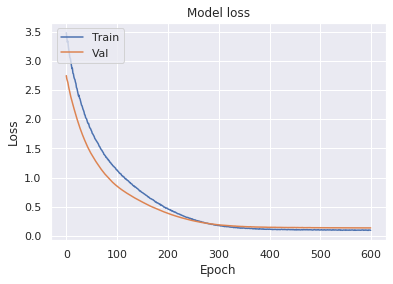



Train Cosine Similarity: 0.9005736112594604, Val Cosine Similarity: 0.4017094075679779


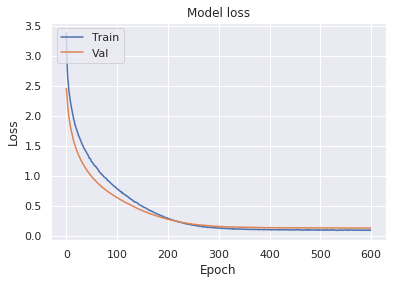



Train Cosine Similarity: 0.9053537249565125, Val Cosine Similarity: 0.5811966061592102


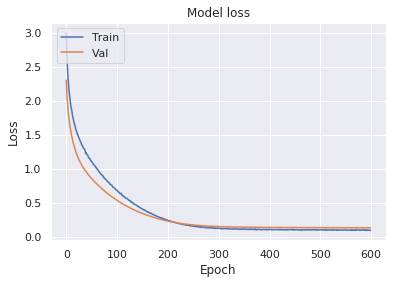



Train Cosine Similarity: 0.9044890403747559, Val Cosine Similarity: 0.48275861144065857


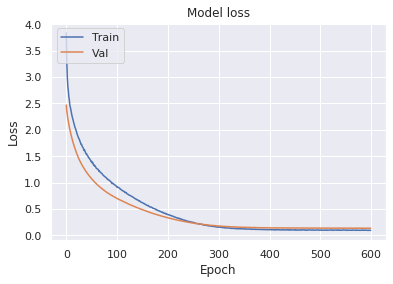



Train Cosine Similarity: 0.9092645645141602, Val Cosine Similarity: 0.6637930870056152


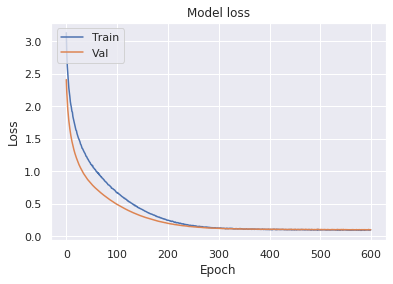



Train Cosine Similarity: 0.9006685614585876, Val Cosine Similarity: 0.5517241358757019


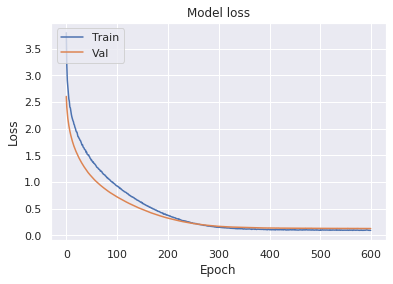



Train Cosine Similarity: 0.9092645645141602, Val Cosine Similarity: 0.6293103694915771


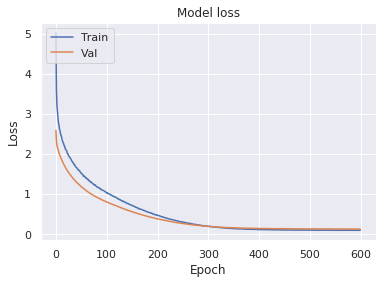



Train Cosine Similarity: 0.8958930373191833, Val Cosine Similarity: 0.6293103694915771


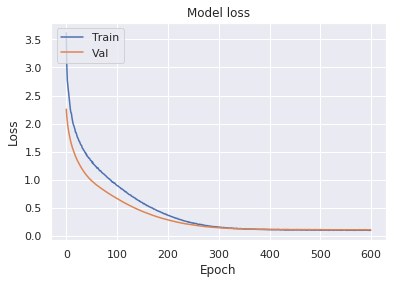



Train Cosine Similarity: 0.9140400886535645, Val Cosine Similarity: 0.37931033968925476


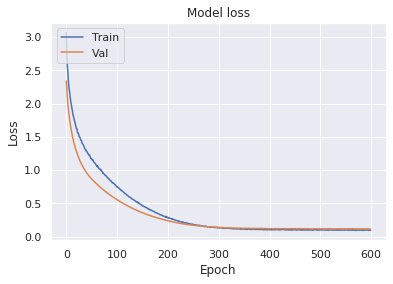



Train Cosine Similarity: 0.9063992500305176, Val Cosine Similarity: 0.4655172526836395


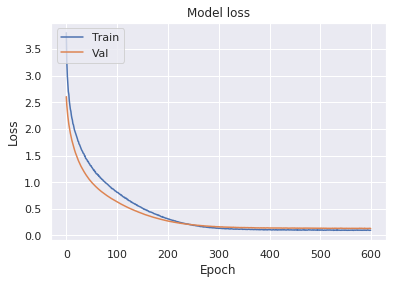



Time Elapsed: 1567.4145832061768
Epochs: 600
Hidden Nodes 1: 50
Hidden Nodes 2: 30
Hidden Nodes 3: 15
Input Dropout Rate: 0.25
Hidden Dropout Rate: 0.2
Activation Function: relu
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd82e184c88>
Stratified 10-Fold Cosine Similarity Avg Score: 0.5220527052879333, Std Score: 0.0972101092338562



In [0]:
optimizer=optimizers.Adam(learning_rate=0.00005)

grid_model(df_train,hidden_nodes_1=50,hidden_nodes_2=30,hidden_nodes_3=15,
           input_dropout=0.25,hidden_dropout=0.2,l2_regularizer=0.01,batch_normalization=False,
           activation_list=['relu'],optimizer=optimizer,epochs=600,two_layer=False,sentence_vector=False)

Train Cosine Similarity: 0.8986615538597107, Val Cosine Similarity: 0.45299145579338074


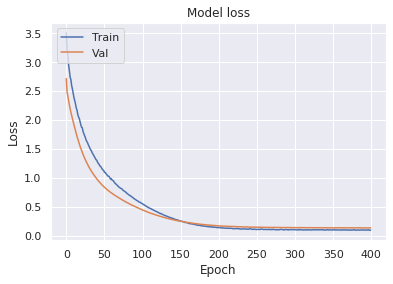



Train Cosine Similarity: 0.90439772605896, Val Cosine Similarity: 0.4188034236431122


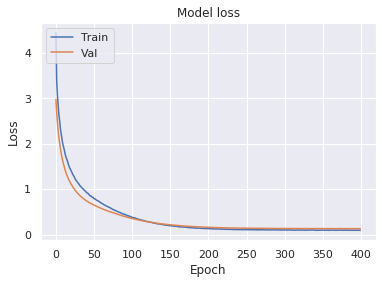



Train Cosine Similarity: 0.8957934975624084, Val Cosine Similarity: 0.5641025900840759


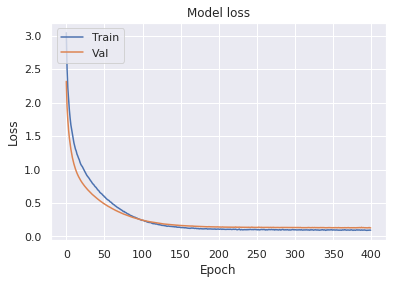



Train Cosine Similarity: 0.9006685614585876, Val Cosine Similarity: 0.4482758641242981


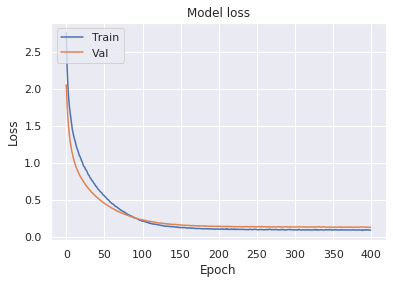



Train Cosine Similarity: 0.9092645645141602, Val Cosine Similarity: 0.6465517282485962


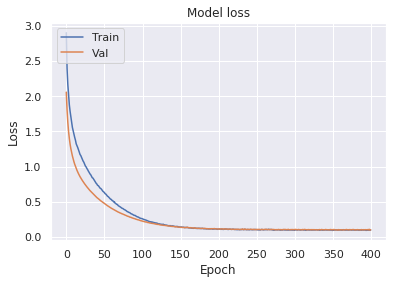



Train Cosine Similarity: 0.910219669342041, Val Cosine Similarity: 0.568965494632721


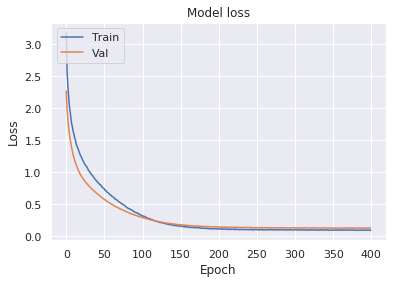



Train Cosine Similarity: 0.9016236662864685, Val Cosine Similarity: 0.5431034564971924


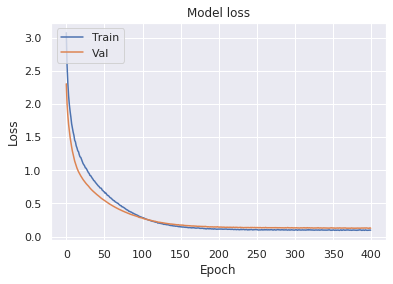



Train Cosine Similarity: 0.8939828276634216, Val Cosine Similarity: 0.6465517282485962


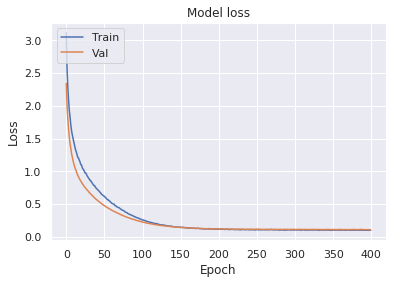



Train Cosine Similarity: 0.9025787711143494, Val Cosine Similarity: 0.4655172526836395


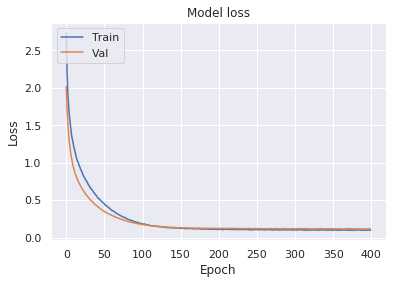



Train Cosine Similarity: 0.910219669342041, Val Cosine Similarity: 0.48275861144065857


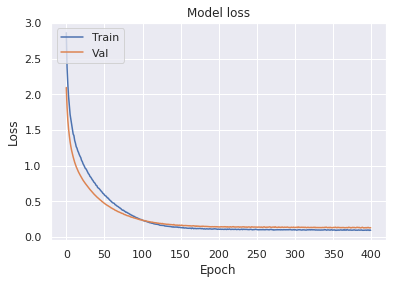



Time Elapsed: 1364.5052936077118
Epochs: 400
Hidden Nodes 1: 50
Hidden Nodes 2: 30
Hidden Nodes 3: 15
Input Dropout Rate: 0.25
Hidden Dropout Rate: 0.2
Activation Function: relu
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8286ee9b0>
Stratified 10-Fold Cosine Similarity Avg Score: 0.5237621068954468, Std Score: 0.07810000330209732



In [0]:
optimizer=optimizers.Adam(learning_rate=0.0001)

grid_model(df_train,hidden_nodes_1=50,hidden_nodes_2=30,hidden_nodes_3=15,
           input_dropout=0.25,hidden_dropout=0.2,l2_regularizer=0.01,batch_normalization=False,
           activation_list=['relu'],optimizer=optimizer,epochs=400,two_layer=False,sentence_vector=False)

Train Cosine Similarity: 0.923518180847168, Val Cosine Similarity: 0.470085471868515


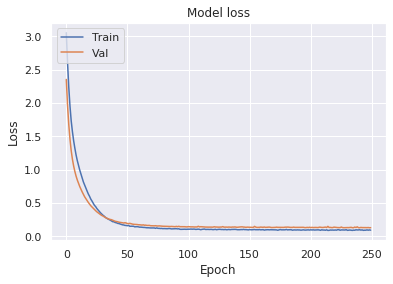



Train Cosine Similarity: 0.913957953453064, Val Cosine Similarity: 0.43589743971824646


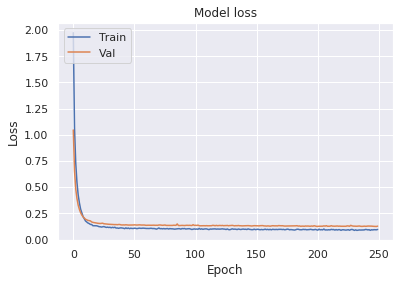



Train Cosine Similarity: 0.9149139523506165, Val Cosine Similarity: 0.632478654384613


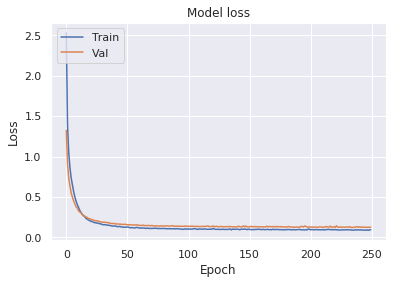



Train Cosine Similarity: 0.9063992500305176, Val Cosine Similarity: 0.4482758641242981


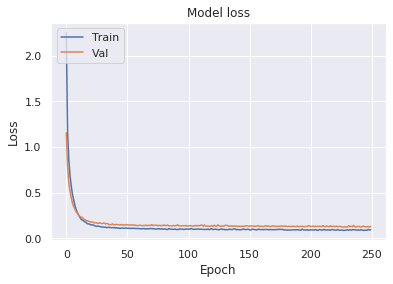



Train Cosine Similarity: 0.9130849838256836, Val Cosine Similarity: 0.6637930870056152


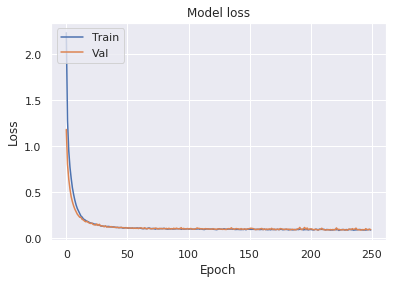



Train Cosine Similarity: 0.9178605675697327, Val Cosine Similarity: 0.5862069129943848


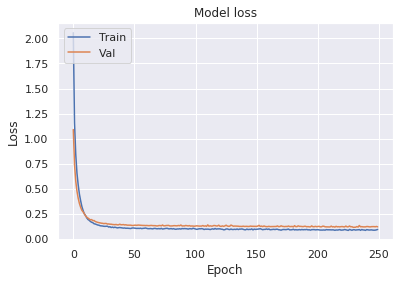



Train Cosine Similarity: 0.8462272882461548, Val Cosine Similarity: 0.5603448152542114


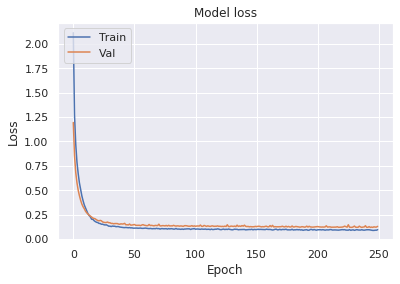



Train Cosine Similarity: 0.9169054627418518, Val Cosine Similarity: 0.5948275923728943


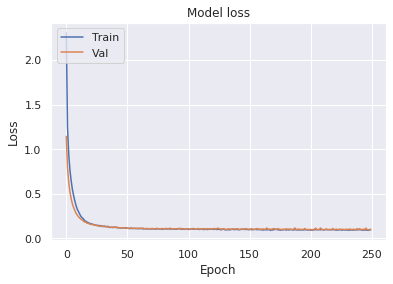



Train Cosine Similarity: 0.9044890403747559, Val Cosine Similarity: 0.4482758641242981


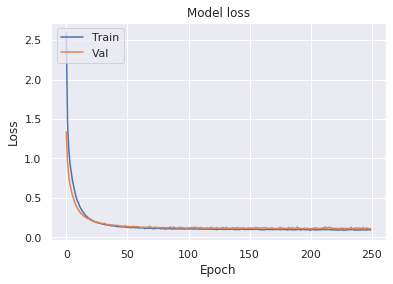



Train Cosine Similarity: 0.9025787711143494, Val Cosine Similarity: 0.5


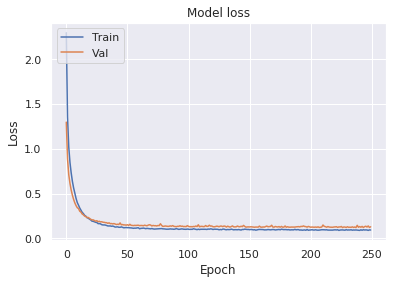



Time Elapsed: 1187.4793140888214
Epochs: 250
Hidden Nodes 1: 50
Hidden Nodes 2: 30
Hidden Nodes 3: 15
Input Dropout Rate: 0.25
Hidden Dropout Rate: 0.2
Activation Function: relu
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd828763e10>
Stratified 10-Fold Cosine Similarity Avg Score: 0.5340185761451721, Std Score: 0.07951498031616211



In [0]:
optimizer=optimizers.Adam(learning_rate=0.0005)

grid_model(df_train,hidden_nodes_1=50,hidden_nodes_2=30,hidden_nodes_3=15,
           input_dropout=0.25,hidden_dropout=0.2,l2_regularizer=0.01,batch_normalization=False,
           activation_list=['relu'],optimizer=optimizer,epochs=250,two_layer=False,sentence_vector=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train Cosine Similarity: 0.923518180847168, Val Cosine Similarity: 0.43589743971824646


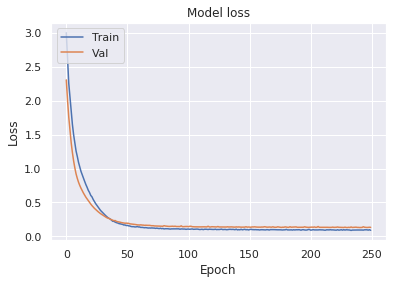



Train Cosine Similarity: 0.9101338386535645, Val Cosine Similarity: 0.4017094075679779


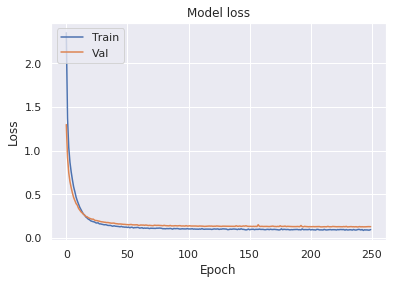



Train Cosine Similarity: 0.8957934975624084, Val Cosine Similarity: 0.5641025900840759


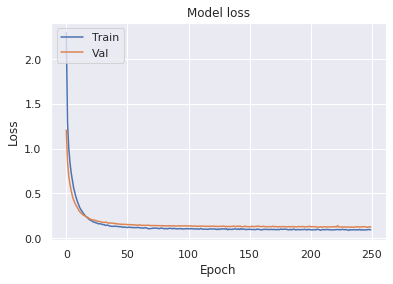



Train Cosine Similarity: 0.9140400886535645, Val Cosine Similarity: 0.5


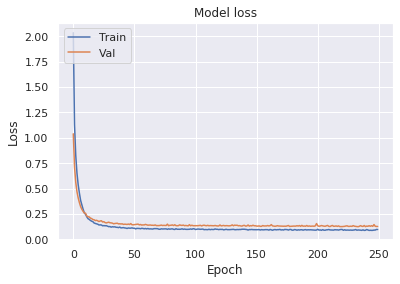



Train Cosine Similarity: 0.903533935546875, Val Cosine Similarity: 0.681034505367279


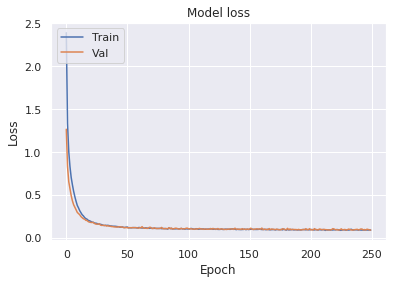



Train Cosine Similarity: 0.9197707772254944, Val Cosine Similarity: 0.6034482717514038


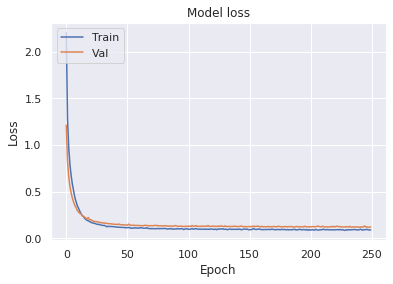



Train Cosine Similarity: 0.9111747741699219, Val Cosine Similarity: 0.5431034564971924


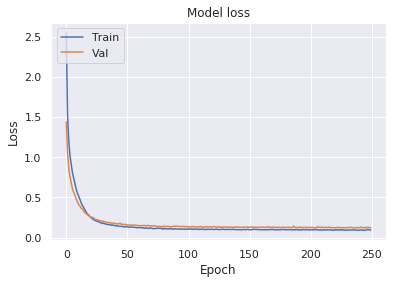



Train Cosine Similarity: 0.9092645645141602, Val Cosine Similarity: 0.5431034564971924


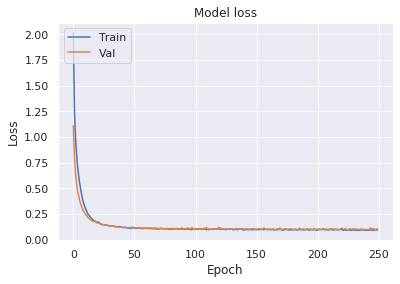



Train Cosine Similarity: 0.8968481421470642, Val Cosine Similarity: 0.5517241358757019


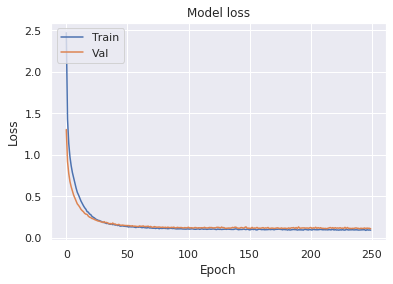



Train Cosine Similarity: 0.8987583518028259, Val Cosine Similarity: 0.48275861144065857


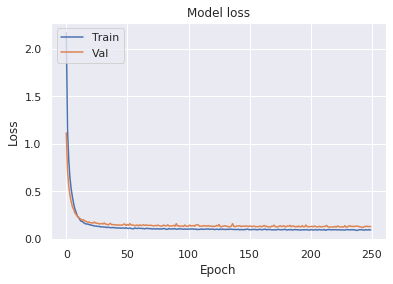



Time Elapsed: 1124.2013537883759
Epochs: 250
Hidden Nodes 1: 50
Hidden Nodes 2: 25
Hidden Nodes 3: 12
Input Dropout Rate: 0.25
Hidden Dropout Rate: 0.2
Activation Function: relu
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f7370d09b38>
Stratified 10-Fold Cosine Similarity Avg Score: 0.5306881666183472, Std Score: 0.07656708359718323



In [0]:
optimizer=optimizers.Adam(learning_rate=0.0005)

grid_model(df_train,hidden_nodes_1=50,hidden_nodes_2=25,hidden_nodes_3=12,
           input_dropout=0.25,hidden_dropout=0.2,l2_regularizer=0.01,batch_normalization=False,
           activation_list=['relu'],optimizer=optimizer,epochs=250,two_layer=False,sentence_vector=False)

Train Cosine Similarity: 0.9063097238540649, Val Cosine Similarity: 0.4188034236431122


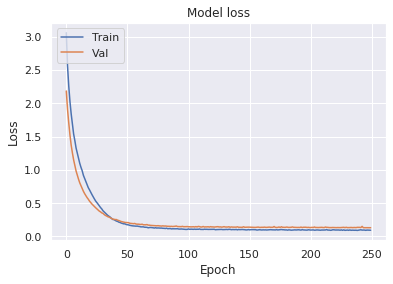



Train Cosine Similarity: 0.9063097238540649, Val Cosine Similarity: 0.43589743971824646


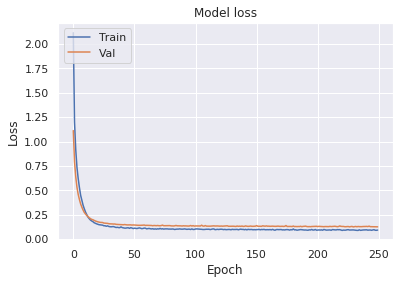



Train Cosine Similarity: 0.9072657823562622, Val Cosine Similarity: 0.6153846383094788


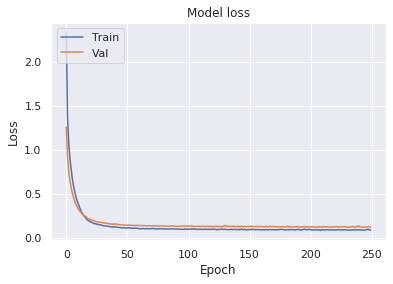



Train Cosine Similarity: 0.9083094596862793, Val Cosine Similarity: 0.5


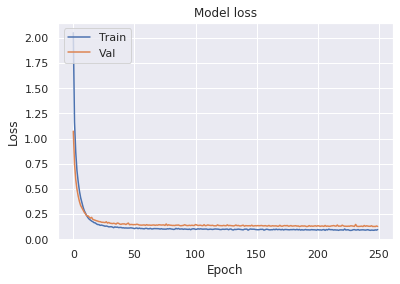



Train Cosine Similarity: 0.9054441452026367, Val Cosine Similarity: 0.6465517282485962


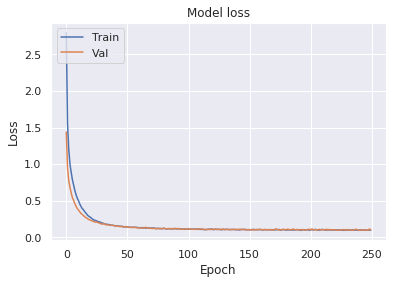



Train Cosine Similarity: 0.927411675453186, Val Cosine Similarity: 0.5517241358757019


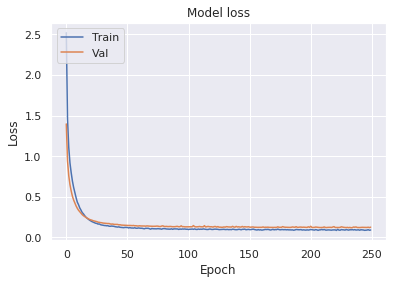



Train Cosine Similarity: 0.9111747741699219, Val Cosine Similarity: 0.5948275923728943


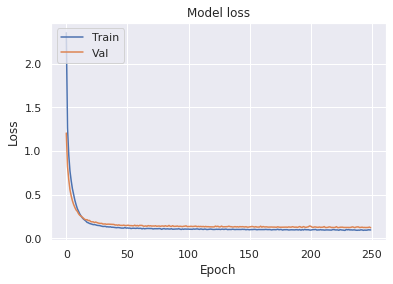



Train Cosine Similarity: 0.9092645645141602, Val Cosine Similarity: 0.5603448152542114


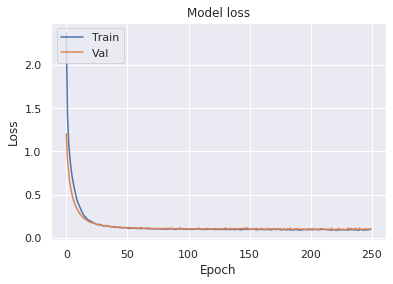



Train Cosine Similarity: 0.9197707772254944, Val Cosine Similarity: 0.4137931168079376


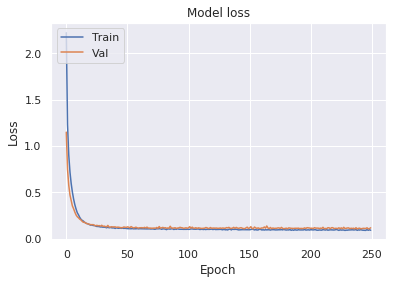



Train Cosine Similarity: 0.9083094596862793, Val Cosine Similarity: 0.5


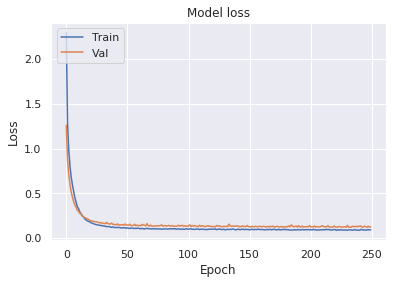



Time Elapsed: 891.1444482803345
Epochs: 250
Hidden Nodes 1: 50
Hidden Nodes 2: 30
Hidden Nodes 3: 10
Input Dropout Rate: 0.25
Hidden Dropout Rate: 0.2
Activation Function: relu
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f3463940fd0>
Stratified 10-Fold Cosine Similarity Avg Score: 0.5237326622009277, Std Score: 0.07912106066942215



In [0]:
optimizer=optimizers.Adam(learning_rate=0.0005)

grid_model(df_train,hidden_nodes_1=50,hidden_nodes_2=30,hidden_nodes_3=10,
           input_dropout=0.25,hidden_dropout=0.2,l2_regularizer=0.01,batch_normalization=False,
           activation_list=['relu'],optimizer=optimizer,epochs=250,two_layer=False,sentence_vector=False)

## Final Model Train

In [0]:
optimizer=optimizers.Adam(learning_rate=0.0005)

final_model=model(df_train,hidden_nodes_1=50,hidden_nodes_2=30,hidden_nodes_3=15,
                  input_dropout=0.25,hidden_dropout=0.2,l2_regularizer=0.01,batch_normalization=False,
                  act='relu',optimizer=optimizer,epochs=250,two_layer=False,sentence_vector=False)

final_model.save("gdrive/My Drive/TA/Seminar 1/Jupyter Notebook/model_MLP.h5")

# MLP Sentence Vector

In [0]:
#Word2Vec Sentence Embedding dataframe
W2V_df_train=W2V_sentence_embedding(df_train)
W2V_df_test=W2V_sentence_embedding(df_test)
# #GloVe Sentence Embedding dataframe
# GloVe_df_train=GloVe_sentence_embedding(df_train)
# GloVe_df_test=GloVe_sentence_embedding(df_test)

## W2V Hyperparameter Tuning

Train Cosine Similarity: 0.7399617433547974, Val Cosine Similarity: 0.5555555820465088


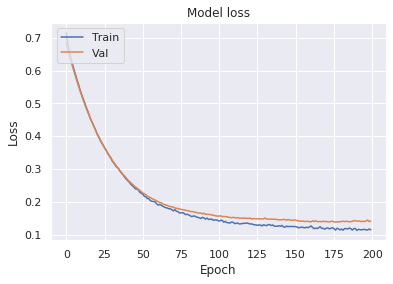



Train Cosine Similarity: 0.8049713373184204, Val Cosine Similarity: 0.470085471868515


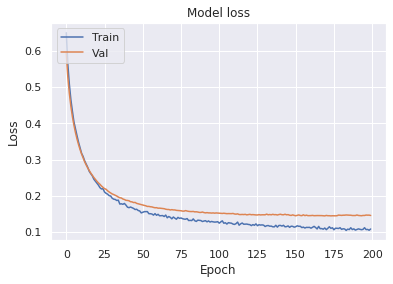



Train Cosine Similarity: 0.7753345966339111, Val Cosine Similarity: 0.5128205418586731


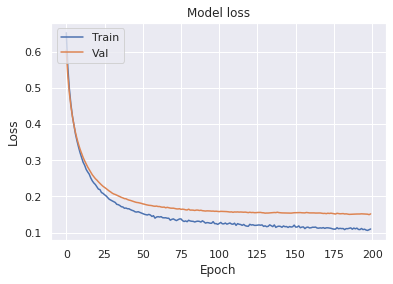



Train Cosine Similarity: 0.7593123316764832, Val Cosine Similarity: 0.5344827771186829


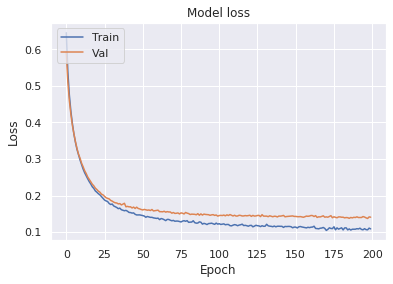



Train Cosine Similarity: 0.7335243821144104, Val Cosine Similarity: 0.681034505367279


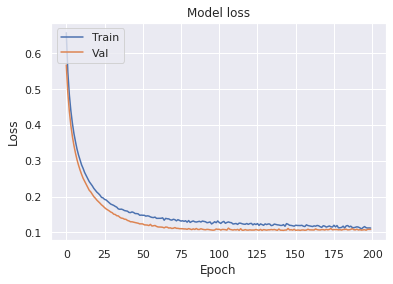



Train Cosine Similarity: 0.7936962842941284, Val Cosine Similarity: 0.568965494632721


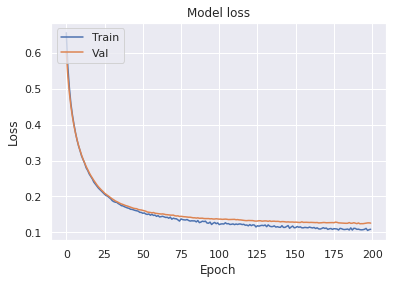



Train Cosine Similarity: 0.7411652207374573, Val Cosine Similarity: 0.5258620977401733


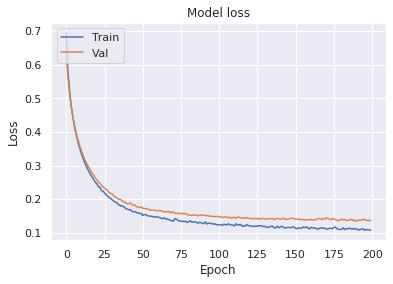



Train Cosine Similarity: 0.7812798619270325, Val Cosine Similarity: 0.681034505367279


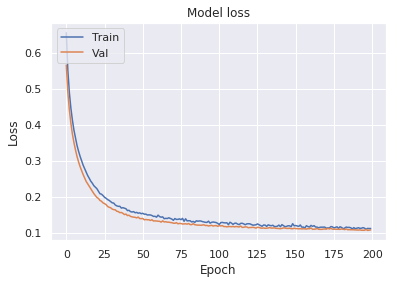



Train Cosine Similarity: 0.7459408044815063, Val Cosine Similarity: 0.5344827771186829


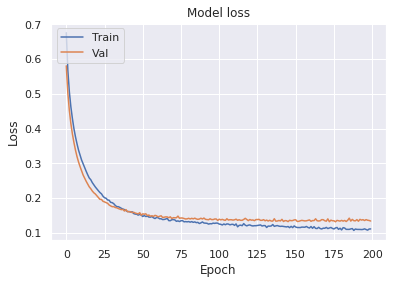



Train Cosine Similarity: 0.7574021220207214, Val Cosine Similarity: 0.568965494632721


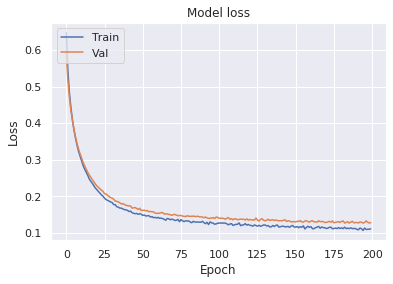



Time Elapsed: 724.9686844348907
Epochs: 200
Hidden Nodes 1: 50
Hidden Nodes 2: 25
Hidden Nodes 3: 10
Input Dropout Rate: 0.25
Hidden Dropout Rate: 0.25
Activation Function: relu
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f3264b1ce48>
Stratified 10-Fold Cosine Similarity Avg Score: 0.5633289217948914, Std Score: 0.06492039561271667



In [0]:
optimizer=optimizers.Adam(learning_rate=0.0001)

grid_model(W2V_df_train,
            two_layer=False,hidden_nodes_1=50,hidden_nodes_2=25,hidden_nodes_3=10,
           input_dropout=0.25,hidden_dropout=0.25,l2_regularizer=0.004,batch_normalization=False,
           activation_list=['relu'],optimizer=optimizer,
           epochs=200,batch_size=32,
           sentence_vector=True)

Train Cosine Similarity: 0.6806883215904236, Val Cosine Similarity: 0.5384615659713745


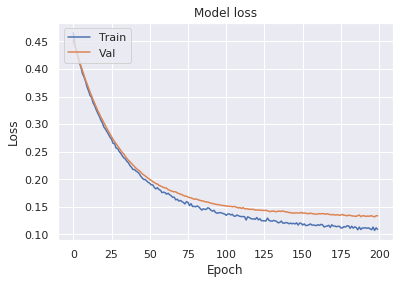



Train Cosine Similarity: 0.6845124363899231, Val Cosine Similarity: 0.470085471868515


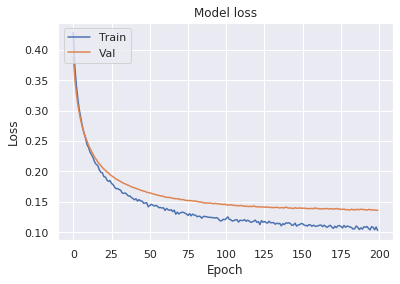



Train Cosine Similarity: 0.6873804926872253, Val Cosine Similarity: 0.4444444477558136


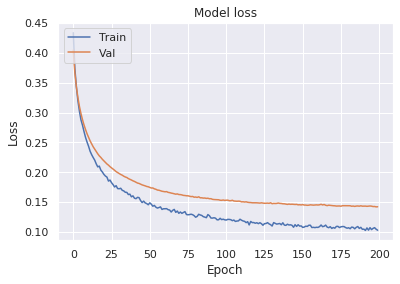



Train Cosine Similarity: 0.6676217913627625, Val Cosine Similarity: 0.5344827771186829


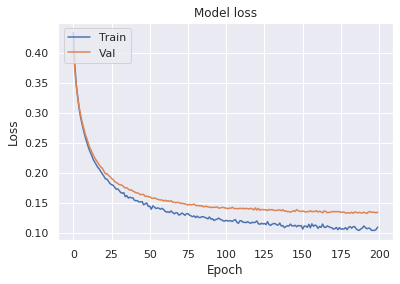



Train Cosine Similarity: 0.670487105846405, Val Cosine Similarity: 0.7155172228813171


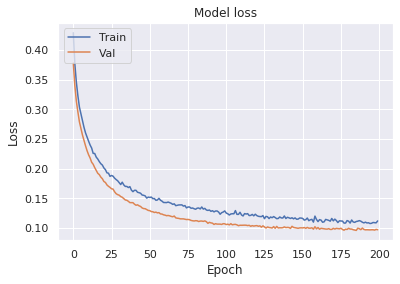



Train Cosine Similarity: 0.7077363729476929, Val Cosine Similarity: 0.5517241358757019


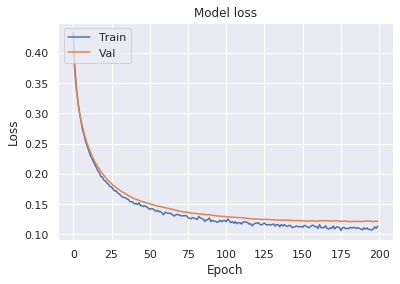



Train Cosine Similarity: 0.6953199505805969, Val Cosine Similarity: 0.5086206793785095


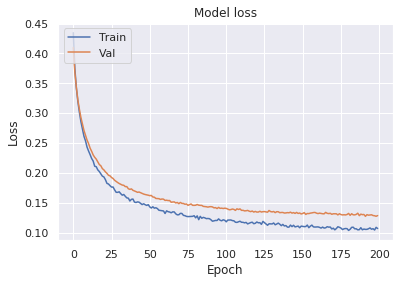



Train Cosine Similarity: 0.6991404294967651, Val Cosine Similarity: 0.6120689511299133


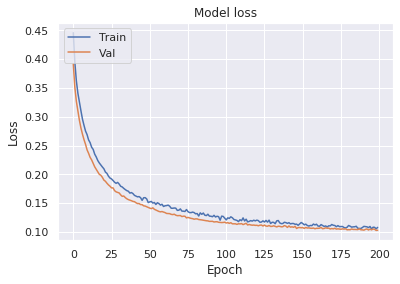



Train Cosine Similarity: 0.7172874808311462, Val Cosine Similarity: 0.5


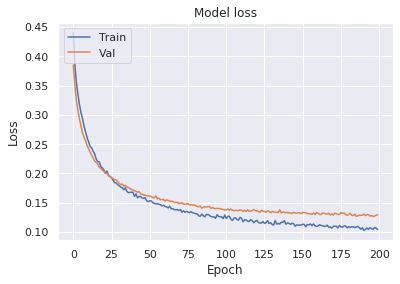



Train Cosine Similarity: 0.7077363729476929, Val Cosine Similarity: 0.5862069129943848


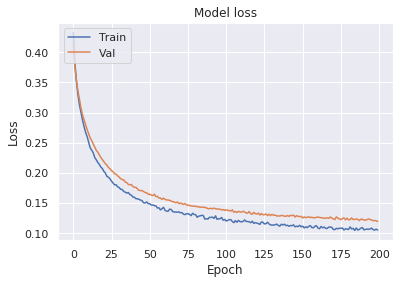



Time Elapsed: 739.4979338645935
Epochs: 200
Hidden Nodes 1: 30
Hidden Nodes 2: 15
Hidden Nodes 3: 0
Input Dropout Rate: 0.25
Hidden Dropout Rate: 0.25
Activation Function: relu
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f3264b1c828>
Stratified 10-Fold Cosine Similarity Avg Score: 0.5461612343788147, Std Score: 0.07384411245584488



In [0]:
optimizer=optimizers.Adam(learning_rate=0.0001)

grid_model(W2V_df_train,
            two_layer=True,hidden_nodes_1=30,hidden_nodes_2=15,hidden_nodes_3=0,
           input_dropout=0.25,hidden_dropout=0.25,l2_regularizer=0.004,batch_normalization=False,
           activation_list=['relu'],optimizer=optimizer,
           epochs=200,batch_size=32,
           sentence_vector=True)

Train Cosine Similarity: 0.7590821981430054, Val Cosine Similarity: 0.5726495981216431


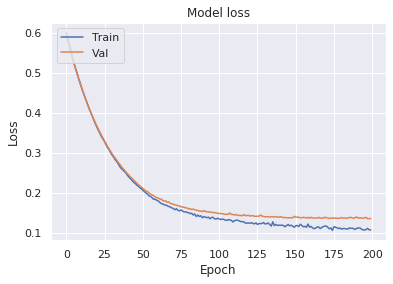



Train Cosine Similarity: 0.8068833947181702, Val Cosine Similarity: 0.43589743971824646


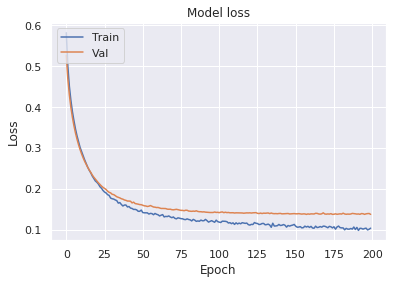



Train Cosine Similarity: 0.7447418570518494, Val Cosine Similarity: 0.4615384638309479


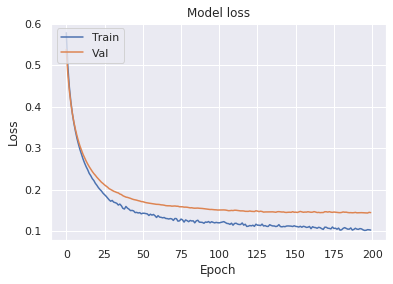



Train Cosine Similarity: 0.7535816431045532, Val Cosine Similarity: 0.568965494632721


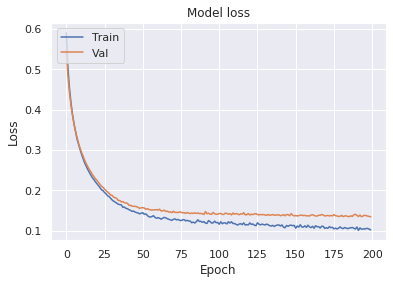



Train Cosine Similarity: 0.760267436504364, Val Cosine Similarity: 0.75


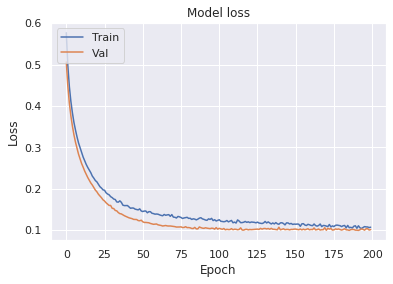



Train Cosine Similarity: 0.789875864982605, Val Cosine Similarity: 0.5517241358757019


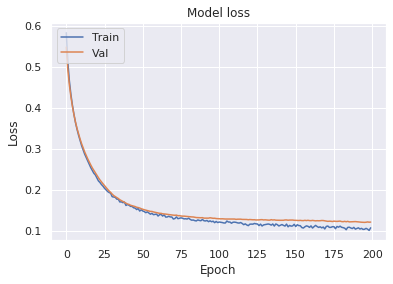



Train Cosine Similarity: 0.7468959093093872, Val Cosine Similarity: 0.5603448152542114


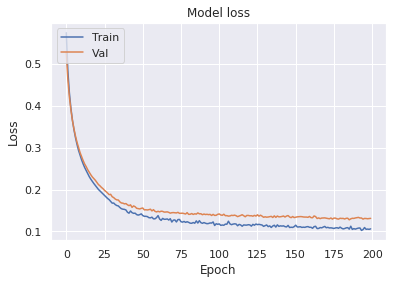



Train Cosine Similarity: 0.7927411794662476, Val Cosine Similarity: 0.6637930870056152


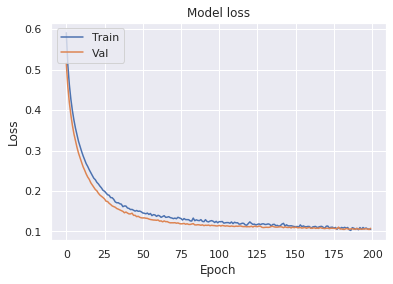



Train Cosine Similarity: 0.7822349667549133, Val Cosine Similarity: 0.5517241358757019


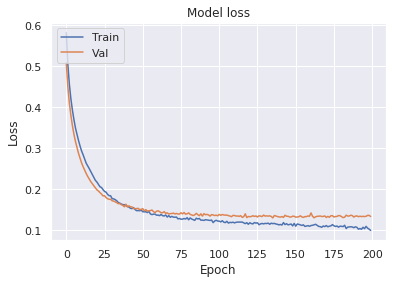



Train Cosine Similarity: 0.7516714334487915, Val Cosine Similarity: 0.5862069129943848


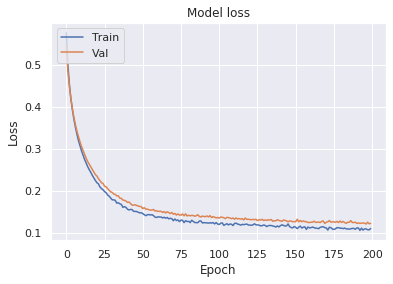



Time Elapsed: 274.86139464378357
Epochs: 200
Hidden Nodes 1: 30
Hidden Nodes 2: 30
Hidden Nodes 3: 30
Input Dropout Rate: 0.25
Hidden Dropout Rate: 0.25
Activation Function: relu
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f95498f2320>
Stratified 10-Fold Cosine Similarity Avg Score: 0.5702844262123108, Std Score: 0.08483850955963135



In [0]:
optimizer=optimizers.Adam(learning_rate=0.0001)

grid_model(W2V_df_train,
            two_layer=False,hidden_nodes_1=30,hidden_nodes_2=30,hidden_nodes_3=30,
           input_dropout=0.25,hidden_dropout=0.25,l2_regularizer=0.004,batch_normalization=False,
           activation_list=['relu'],optimizer=optimizer,
           epochs=200,batch_size=32,
           sentence_vector=True)

## W2V Full Model Train

In [0]:
final_model=model(W2V_df_train,
            two_layer=False,hidden_nodes_1=30,hidden_nodes_2=30,hidden_nodes_3=30,
           input_dropout=0.25,hidden_dropout=0.25,l2_regularizer=0.004,batch_normalization=False,
           act='relu',optimizer=optimizer,
           epochs=200,batch_size=32,
           sentence_vector=True)

final_model.save("gdrive/My Drive/TA/Seminar 1/Jupyter Notebook/model_MLP_W2V_Sentence_Vector.h5")